In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_ANIMAL10_TRAIN = Path("/kaggle/input/animal-10/splitData/Train")
PROCESSED_DATASET_PATH_ANIMAL10_TEST = Path("/kaggle/input/animal-10/splitData/Test")
PROCESSED_DATASET_PATH_ANIMAL10_VAL = Path("/kaggle/input/animal-10/splitData/Validation")

# PRETRAINED_MODEL = "/kaggle/input/modele2/e2.pth"

print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_ANIMAL10_TEST, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)
print(val_set)


14676 2094 4199 ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Dataset ImageFolder
    Number of datapoints: 2094
    Root location: /kaggle/input/animal-10/splitData/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


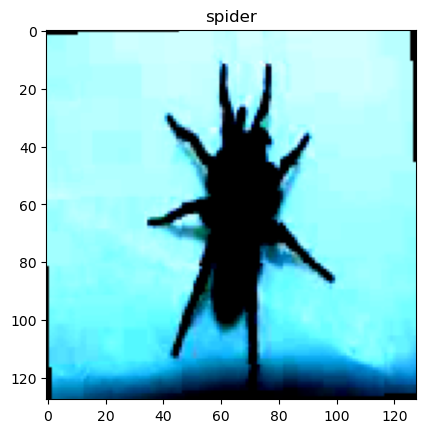

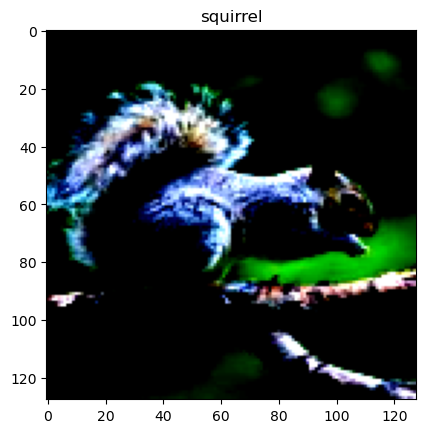

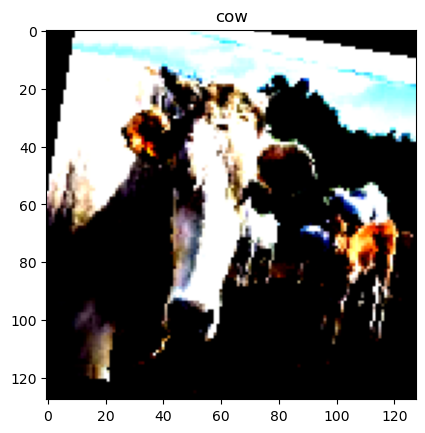

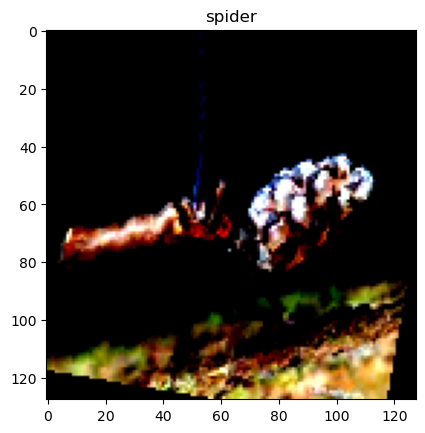

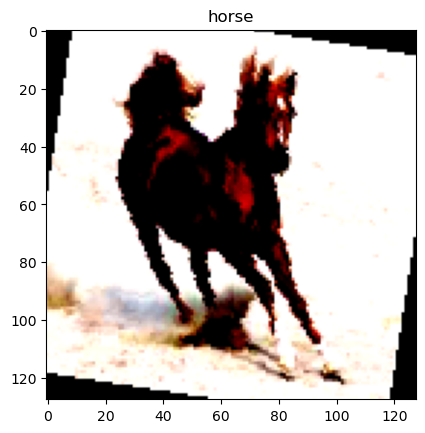

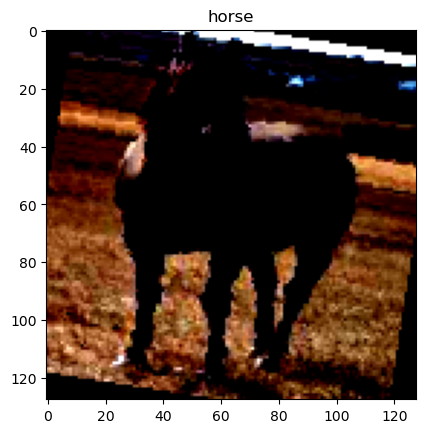

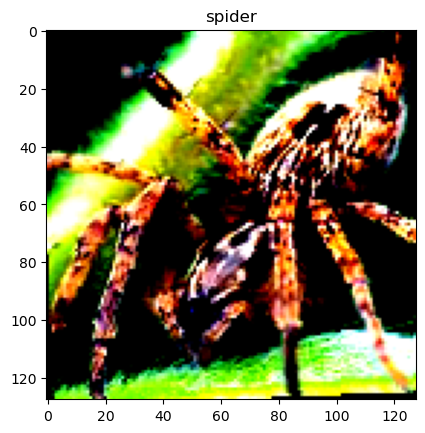

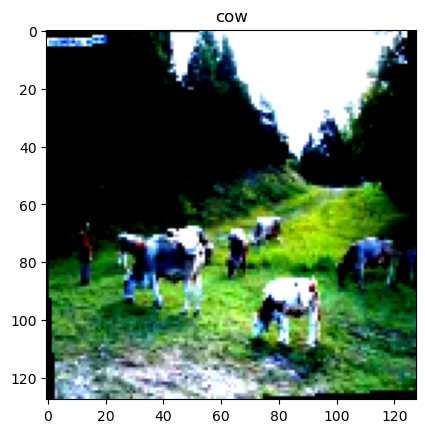

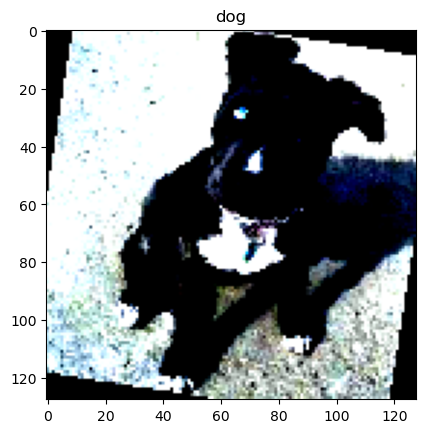

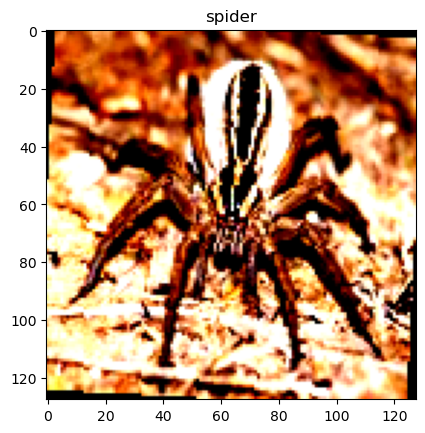

8


In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(10):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()
print(len(train_set.classes))

In [4]:
print("Unique classes number : ",len(train_set.classes))
print("Classes : ", train_set.classes)

Unique classes number :  8
Classes :  ['cat', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [5]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
model = models.vgg11(num_classes=len(train_set.classes),pretrained=False)
model = model.to(device)
model.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
import os
os.makedirs("/kaggle/working/mods")

In [8]:
import pandas as pd
open("/kaggle/working/logs.csv", "a", newline="")
log_file = open("/kaggle/working/logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    try:
        if mode == 'train':
            model.train()
        elif mode == 'val':
            model.eval()

        loss = correct = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)

            if mode == 'train':
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            loss += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
        loss = loss/len(dataset)
        accuracy = correct/len(dataset)
        return loss, accuracy
    except:
        pass

result_df = pd.DataFrame(columns=['epoch', 'train_loss','train_acc','val_loss','val_acc'])
result_list = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    try:
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        row_dict = {'epoch':epoch,'train_loss':float(train_cost),'train_acc':train_score,'val_loss':float(test_cost),'val_acc':test_score} 
        result_list.append(row_dict)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"/kaggle/working/mods/_e{epoch}.pth")
    except:
        pass
result_df = pd.DataFrame.from_dict(result_list)

Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

1 0.0006716027855873108 0.3318342872717362 0.01203121431171894 0.35959885386819485


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

2 0.0006206645630300045 0.45434723357863177 0.01379955094307661 0.5234001910219676


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

3 0.00026685671764425933 0.5245979831016626 0.007323547266423702 0.5272206303724928


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

4 0.00012765762221533805 0.5679340419732897 0.007039733696728945 0.559694364851958


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

5 0.0002936560194939375 0.6035023167075497 0.00934604648500681 0.6160458452722063


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

6 0.0002547074109315872 0.6394112837285364 0.008159535005688667 0.6680993314231136


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

7 0.0001926080440171063 0.673003543199782 0.004132217261940241 0.6752626552053486


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

8 0.00023773153952788562 0.6974652493867539 0.003516710828989744 0.6843361986628462


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

9 0.0004007358802482486 0.7183156173344235 0.0109192980453372 0.6375358166189111


Train:   0%|          | 0/918 [00:00<?, ?it/s]

Val:   0%|          | 0/131 [00:00<?, ?it/s]

10 6.421341822715476e-05 0.7465249386753884 0.006713365204632282 0.7378223495702005


In [ ]:
# import shutil
# shutil.make_archive('/kaggle/working/', 'zip', 'Output-Animal10')

In [9]:
BATCH_SIZE = 10


PRETRAINED_MODEL = "/kaggle/working/mods/_e8.pth"

In [ ]:
result_df

In [10]:
testset = torchvision.datasets.ImageFolder( PROCESSED_DATASET_PATH_ANIMAL10_TEST,transform = transforms)
testloader = torch.utils.data.DataLoader(testset  , batch_size=BATCH_SIZE)

In [11]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.vgg11(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

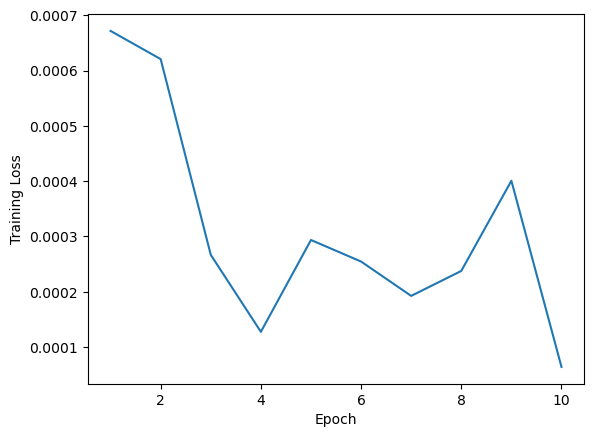

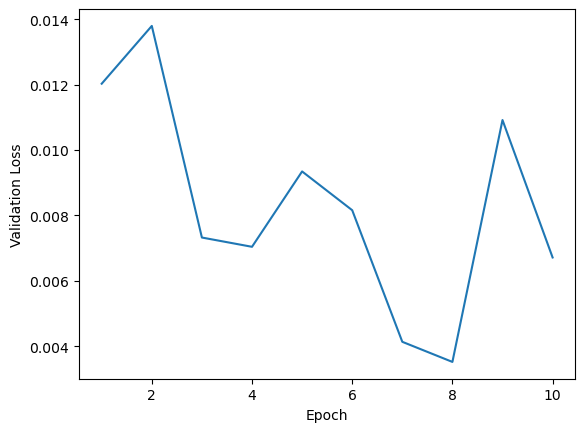

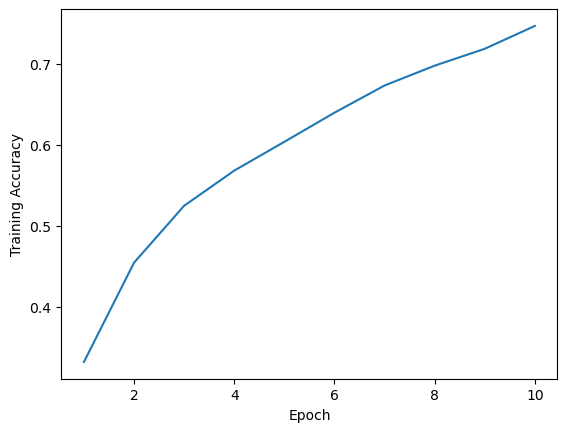

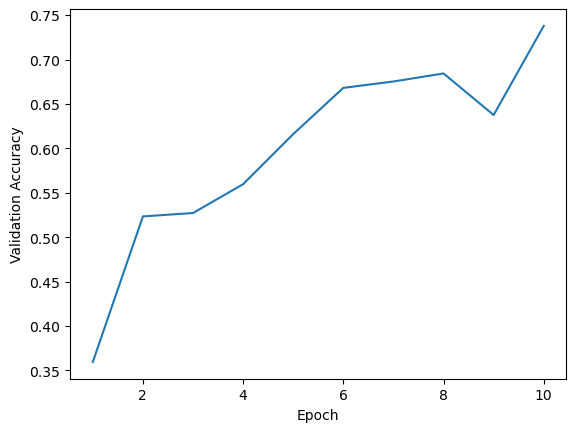

In [12]:
import pandas as pd

# df = pd.read_csv("../input/animal10csv/Mobilenet.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(result_df["epoch"], result_df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(result_df["epoch"], result_df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(result_df["epoch"], result_df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(result_df["epoch"], result_df["val_acc"])
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in testloader:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output]) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels]) # Save Truth

# constant for classes
classes = trainset.classes
# print(y_pred)
# print(y_true)

# Build confusion matrix
cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/output/confusion_vgg_animal10.png')

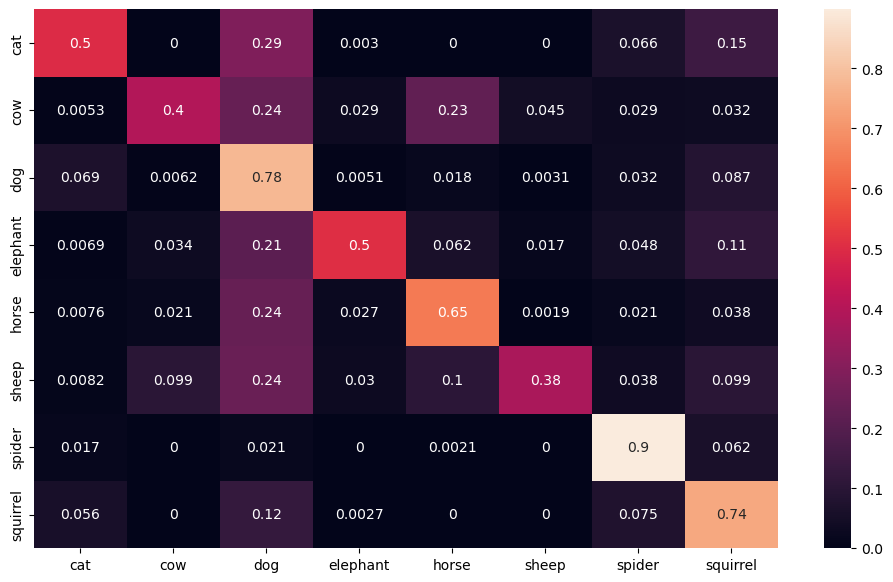

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [15]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=testset.classes))

Overall Accuracy:  67.61  %
              precision    recall  f1-score   support

         cat       0.59      0.50      0.54       335
         cow       0.70      0.40      0.51       374
         dog       0.59      0.78      0.67       973
    elephant       0.77      0.50      0.61       290
       horse       0.68      0.65      0.66       525
       sheep       0.84      0.38      0.52       364
      spider       0.87      0.90      0.88       965
    squirrel       0.48      0.74      0.59       373

    accuracy                           0.68      4199
   macro avg       0.69      0.60      0.62      4199
weighted avg       0.70      0.68      0.67      4199

